In [152]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
weekly_table = nfl.import_weekly_data([2023, 2022])
yearly_table = nfl.import_seasonal_data([2023, 2022])
weekly = pd.DataFrame(weekly_table)
yearly = pd.DataFrame(yearly_table)

weekly['half_ppr'] = (weekly['fantasy_points'] + weekly['fantasy_points_ppr']) / 2
yearly['half_ppr'] = (yearly['fantasy_points'] + yearly['fantasy_points_ppr']) / 2

qb_weekly = weekly[weekly['position_group'] == 'QB']
rb_weekly = weekly[weekly['position_group'] == 'RB']
wr_weekly = weekly[weekly['position_group'] == 'WR']
te_weekly = weekly[weekly['position_group'] == 'TE']
k_weekly = weekly[weekly['position'] == 'K']

qbs = qb_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()
rbs = rb_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()
wrs = wr_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()
tes = te_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()
ks = k_weekly[["player_id", "player_name", "season", "recent_team"]].drop_duplicates()

qb_yearly = pd.merge(yearly, qbs, how="inner", on=['player_id', 'season'])
rb_yearly = pd.merge(yearly, rbs, how="inner", on=['player_id', 'season'])
wr_yearly = pd.merge(yearly, wrs, how="inner", on=['player_id', 'season'])
te_yearly = pd.merge(yearly, tes, how="inner", on=['player_id', 'season'])
k_yearly = pd.merge(yearly, ks, how="inner", on=['player_id', 'season'])

# training_wrs = wr_yearly[wr_yearly['season'] == 2022].merge(wr_yearly[wr_yearly['season'] == 2023], qbs, how="inner", on=['player_id', 'season'])

wr_yearly = wr_yearly[(wr_yearly.groupby('player_id').transform('size') == 2) & (wr_yearly.groupby(['player_id','season']).transform('size') == 1)]
qb_yearly = qb_yearly[qb_yearly.groupby('player_id').transform('size') == 2]
rb_yearly = rb_yearly[rb_yearly.groupby('player_id').transform('size') == 2]
te_yearly = te_yearly[te_yearly.groupby('player_id').transform('size') == 2]
k_yearly = k_yearly[k_yearly.groupby('player_id').transform('size') == 2]

Downcasting floats.


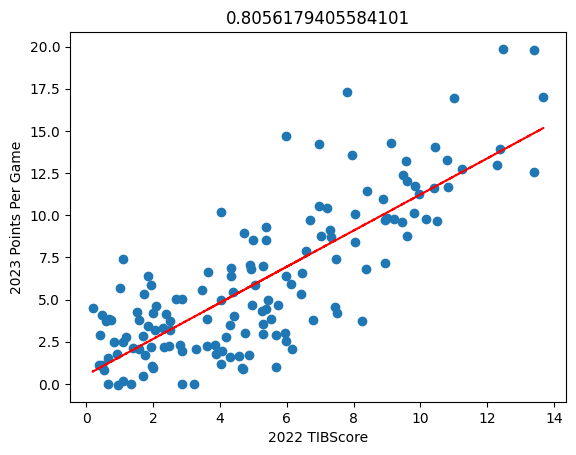

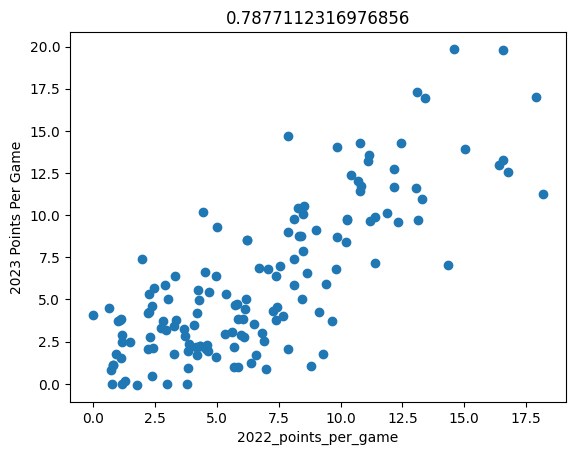

In [172]:
half_ppr = 'half_ppr'

rec_x_labs = ['receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr_x','tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh',
       'rfd_sh', 'rtdfd_sh','points_per_touchdown']

wr_yearly['points_per_game'] = wr_yearly[half_ppr] / wr_yearly['games']
wr_yearly['tds_per_game'] = wr_yearly['receiving_tds'] / wr_yearly['games']
wr_yearly['points_per_reception'] = wr_yearly[half_ppr] / wr_yearly['receptions']
wr_yearly['TIBScore'] = 0

wr_yearly['points_per_touchdown'] = (wr_yearly['half_ppr'] / (wr_yearly['receiving_tds'] + wr_yearly['games']))

cor_values = {}
max_values = {}
for x_labs in rec_x_labs:
    custom_weight = 1
    cor_values[x_labs] = (np.corrcoef(wr_yearly[x_labs], wr_yearly[half_ppr])[0][1]) ** 2
    max_values[x_labs] = wr_yearly[x_labs].max()

for x_lab in rec_x_labs:
    for i, player in wr_yearly.iterrows():
            wr_yearly.loc[(wr_yearly['player_id'] == player['player_id']) & (wr_yearly['season'] == player['season']), 'TIBScore'] += cor_values[x_lab] * (player[x_lab] / max_values[x_lab])
    

# wr_yearly[['player_name','target_share','half_ppr']].sort_values(by='', ascending=True)

wr_predictions = pd.DataFrame()
for player in wr_yearly['player_id'].unique():
    wr_prediction = pd.DataFrame()
    wr_prediction['player_name'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['player_name'].values
    same_team = (wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['recent_team'].values == wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2023)]['recent_team'].values)
    wr_prediction['same_team'] = 'yes' if same_team else 'no'
    wr_prediction['2022_half_ppr'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['half_ppr'].values
    wr_prediction['2023_half_ppr'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2023)]['half_ppr'].values
    wr_prediction['2022_points_per_game'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['points_per_game'].values
    wr_prediction['2023_points_per_game'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2023)]['points_per_game'].values
    wr_prediction['2022 TIBScore'] = wr_yearly[(wr_yearly['player_id'] == player) & (wr_yearly['season'] == 2022)]['TIBScore'].values
    wr_prediction['points_per_game_diff'] = wr_prediction['2023_points_per_game'] - wr_prediction['2022_points_per_game'].values
    wr_predictions = pd.concat([wr_predictions, wr_prediction], ignore_index=True)

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):   
#     print(wr_predictions[wr_predictions['same_team'] == 'yes'])

wr_predictions_same_team = wr_predictions[(np.isinf(wr_predictions['2022 TIBScore'].values) == False)]

plt.figure(1)
plt.scatter(wr_predictions_same_team['2022 TIBScore'], wr_predictions_same_team['2023_points_per_game'])
z = np.polyfit(wr_predictions_same_team['2022 TIBScore'], wr_predictions_same_team['2023_points_per_game'], 1)
p = np.poly1d(z)
plt.xlabel('2022 TIBScore')
plt.ylabel('2023 Points Per Game')
plt.title(np.corrcoef(wr_predictions_same_team['2022 TIBScore'], wr_predictions_same_team['2023_points_per_game'])[0][1])
plt.plot(wr_predictions_same_team['2022 TIBScore'], p(wr_predictions_same_team['2022 TIBScore']), "r--")

plt.figure(2)
plt.scatter(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'])
# z2 = np.polyfit(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'], 1)
# p2 = np.poly1d(z2)
plt.xlabel('2022_points_per_game')
plt.ylabel('2023 Points Per Game')
plt.title(np.corrcoef(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'])[0][1])
# plt.plot(wr_predictions_same_team['2022_points_per_game'], p2(wr_predictions_same_team['2022 TIBScore']), "r--")

plt.show()



In [173]:
wr_projections = pd.read_csv('FantasyPros_Fantasy_Football_Projections_WR.csv')
wr_projections = wr_projections.add_suffix('_2024')
wr_projections['player_name'] = wr_projections['Player_2024'].str.get(0) + '.' + wr_projections['Player_2024'].str.split(' ').str[1]

wr_stats_2024 = pd.merge(wr_projections, wr_yearly, how="inner", on=['player_name'])
wr_yearly['TIBScore'] = 0
wr_yearly['AppliedTIBScore'] = 0

wr_projections_2023 = pd.read_csv('SleeperPredictions.csv')
wr_projections_2023['ppg'] = wr_projections_2023['projected_points'] / 17
wr_projections_2023['projected_points_per_reception'] = wr_projections_2023['projected_points'] / wr_projections_2023['projected_rec']
wr_projections_2023['projected_tds_per_game'] = wr_projections_2023['projected_rec_tds'] / 17
wr_projections_2023['projected_points_per_touchdown'] = wr_projections_2023['projected_points'] / (wr_projections_2023['projected_rec_tds'] + 1)
wr_projections_2023['projected_rec_per_game'] = wr_projections_2023['projected_rec'] / 17
wr_projections_2023['projected_yds_per_game'] = wr_projections_2023['projected_rec_yds'] / 17

wr_yearly['points_per_game'] = wr_yearly[half_ppr] / wr_yearly['games']
wr_yearly['points_per_reception'] = wr_yearly[half_ppr] / wr_yearly['receptions']
wr_yearly['points_per_touchdown'] = (wr_yearly[half_ppr] / wr_yearly['receiving_tds'] + 1)
wr_yearly['tds_per_game'] = wr_yearly['receiving_tds'] / wr_yearly['games']
wr_yearly['rec_per_game'] = wr_yearly['receptions'] / wr_yearly['games']
wr_yearly['yds_per_game'] = wr_yearly['receiving_yards'] / wr_yearly['games']


In [189]:
sleeper_2023 = pd.read_csv('SleeperPredictions.csv')
sleeper_2023['ppg'] = sleeper_2023['projected_points'] / 17
sleeper_2023['projected_points_per_reception'] = sleeper_2023['projected_points'] / sleeper_2023['projected_rec']
sleeper_2023['projected_rec_tds_per_game'] = sleeper_2023['projected_rec_tds'] / 17
sleeper_2023['projected_points_per_touchdown'] = sleeper_2023['projected_points'] / (sleeper_2023['projected_rec_tds'] + 1)
sleeper_2023['projected_rec_per_game'] = sleeper_2023['projected_rec'] / 17
sleeper_2023['projected_rec_yds_per_game'] = sleeper_2023['projected_rec_yds'] / 17

labels = {}
labels['receptions'] = ['receptions', 'projected_rec']
labels['receiving_yards'] = ['receiving_yards', 'projected_rec_yds']
labels['receiving_tds'] = ['receiving_tds', 'projected_rec_tds']
labels['points_per_game'] = ['points_per_game', 'ppg']
labels['points_per_reception'] = ['points_per_reception', 'projected_points_per_reception']
labels['points_per_touchdown'] = ['points_per_touchdown', 'projected_points_per_touchdown']
labels['tds_per_game'] = ['tds_per_game', 'projected_rec_tds_per_game']
labels['rec_per_game'] = ['rec_per_game', 'projected_rec_per_game']
labels['yds_per_game'] = ['yds_per_game', 'projected_rec_yds_per_game']

wr_yearly = pd.merge(sleeper_2023, wr_yearly, how="inner", on=['player_name'])

stat_projection_correlations = {}
for key in labels:
    stat_projection_correlations[key] = np.corrcoef(sleeper_2023_joined[labels[key][0]], sleeper_2023_joined[labels[key][1]])[0][1]

stat_projection_correlations.pop('points_per_touchdown')

c:\Python310\lib\site-packages\numpy\lib\function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


nan

In [190]:
default_coeff = 0.1
stat_categories = [
'tds_per_game',
'rec_per_game',
'yds_per_game']

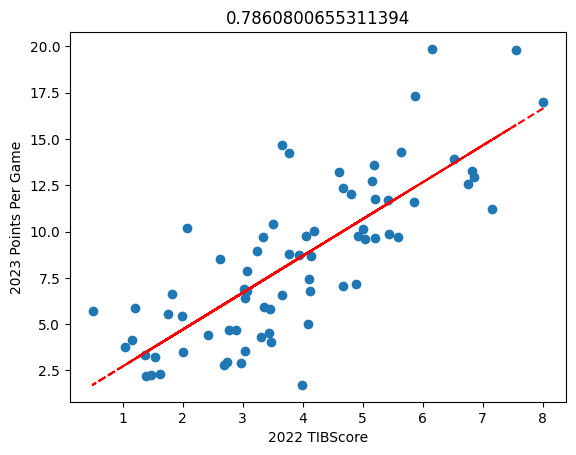

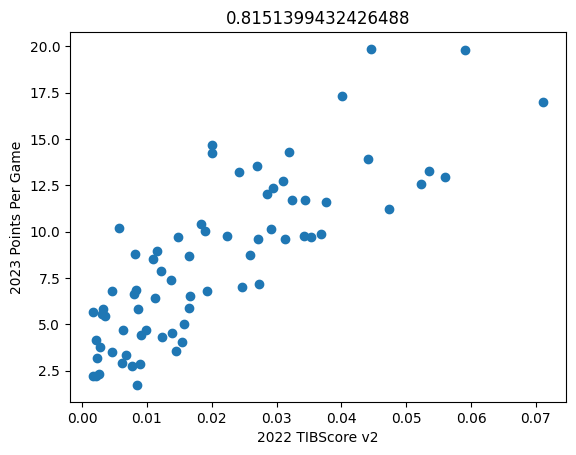

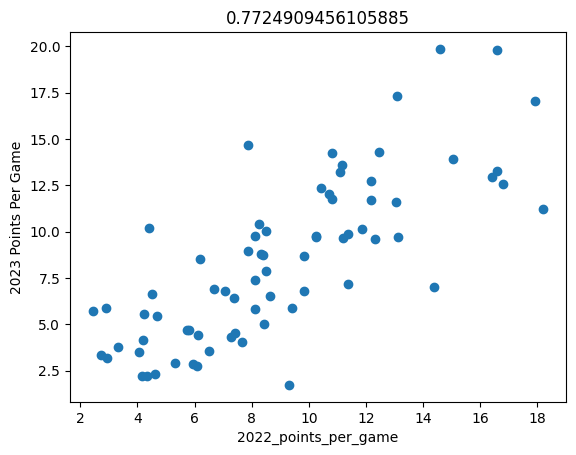

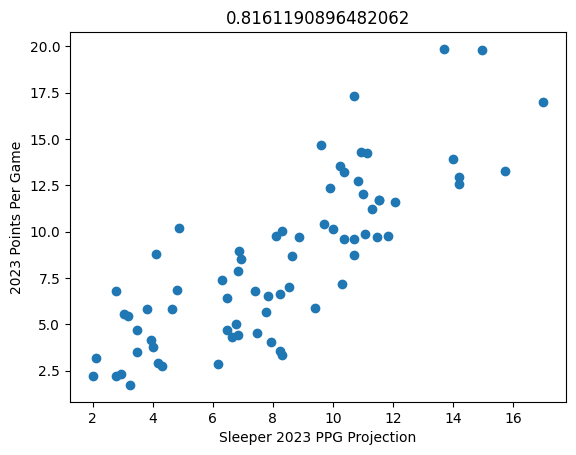

In [194]:
wr_yearly['TIBScore'] = 0
wr_yearly['TIBScore_2'] = 0
wr_yearly['TIBScore_3'] = 0


cor_values = {}
max_values = {}
for x_labs in stat_categories:
    custom_weight = 1
    cor_values[x_labs] = (np.corrcoef(wr_yearly[x_labs], wr_yearly[half_ppr])[0][1]) ** 2
    max_values[x_labs] = wr_yearly[x_labs].max()

for x_lab in stat_categories:
    projection_scorr = stat_projection_correlations.get(x_lab, default_coeff)
    point_weight = 1
    if x_lab == 'tds_per_game':
        point_weight = 6
    elif x_lab == 'rec_per_game':
        point_weight = 1
    elif x_lab == 'yds_per_game':
        point_weight = 0.2
    for i, player in wr_yearly.iterrows():
        wr_yearly.loc[(wr_yearly['player_id'] == player['player_id']) & (wr_yearly['season'] == player['season']), 'TIBScore'] += (cor_values[x_lab]**5) * player[x_lab] * point_weight
        wr_yearly.loc[(wr_yearly['player_id'] == player['player_id']) & (wr_yearly['season'] == player['season']), 'TIBScore_2'] += (cor_values[x_lab]**9) * (projection_scorr**5) * player[x_lab] * point_weight * (player['projected_rec'] / 2000)

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):   
    # print(wr_yearly[(np.isinf(wr_yearly['TIBScore_2'].values) == False)][['player_name', 'TIBScore', 'TIBScore_2', 'receptions', 'receiving_tds']])

wr_yearly_merged = pd.merge(wr_projections_2023, wr_yearly, how="inner", on=['player_name'])

wr_predictions = pd.DataFrame()
for player in wr_yearly_merged['player_id'].unique():
    wr_prediction = pd.DataFrame()
    wr_prediction['player_name'] = wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2022)]['player_name'].values
    same_team = (wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2022)]['recent_team'].values == wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2023)]['recent_team'].values)
    wr_prediction['same_team'] = 'yes' if same_team else 'no'
    wr_prediction['2022_half_ppr'] = wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2022)]['half_ppr'].values
    wr_prediction['2023_half_ppr'] = wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2023)]['half_ppr'].values
    wr_prediction['2022_points_per_game'] = wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2022)]['points_per_game'].values
    wr_prediction['2023_points_per_game'] = wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2023)]['points_per_game'].values
    wr_prediction['Sleeper 2023 PPG Projection'] = wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2023)]['ppg_x'].values
    wr_prediction['2022 TIBScore'] = wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2022)]['TIBScore'].values
    wr_prediction['2022 TIBScore v2'] = wr_yearly_merged[(wr_yearly_merged['player_id'] == player) & (wr_yearly_merged['season'] == 2022)]['TIBScore_2'].values
    wr_prediction['points_per_game_diff'] = wr_prediction['2023_points_per_game'] - wr_prediction['2022_points_per_game'].values
    wr_predictions = pd.concat([wr_predictions, wr_prediction], ignore_index=True)

wr_predictions_same_team = wr_predictions[(np.isinf(wr_predictions['2022 TIBScore'].values) == False) & (wr_predictions['same_team'] == 'yes')]

plt.figure(1)
plt.scatter(wr_predictions_same_team['2022 TIBScore'], wr_predictions_same_team['2023_points_per_game'])
z = np.polyfit(wr_predictions_same_team['2022 TIBScore'], wr_predictions_same_team['2023_points_per_game'], 1)
p = np.poly1d(z)
plt.xlabel('2022 TIBScore')
plt.ylabel('2023 Points Per Game')
plt.title(np.corrcoef(wr_predictions_same_team['2022 TIBScore'], wr_predictions_same_team['2023_points_per_game'])[0][1])
plt.plot(wr_predictions_same_team['2022 TIBScore'], p(wr_predictions_same_team['2022 TIBScore']), "r--")

plt.figure(2)
plt.scatter(wr_predictions_same_team['2022 TIBScore v2'], wr_predictions_same_team['2023_points_per_game'])
plt.xlabel('2022 TIBScore v2')
plt.ylabel('2023 Points Per Game')
plt.title(np.corrcoef(wr_predictions_same_team['2022 TIBScore v2'], wr_predictions_same_team['2023_points_per_game'])[0][1])

plt.figure(3)
plt.scatter(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'])
# z2 = np.polyfit(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'], 1)
# p2 = np.poly1d(z2)
plt.xlabel('2022_points_per_game')
plt.ylabel('2023 Points Per Game')
plt.title(np.corrcoef(wr_predictions_same_team['2022_points_per_game'], wr_predictions_same_team['2023_points_per_game'])[0][1])
# plt.plot(wr_predictions_same_team['2022_points_per_game'], p2(wr_predictions_same_team['2022 TIBScore']), "r--")

plt.figure(4)
plt.scatter(wr_predictions_same_team['Sleeper 2023 PPG Projection'], wr_predictions_same_team['2023_points_per_game'])
plt.xlabel('Sleeper 2023 PPG Projection')
plt.ylabel('2023 Points Per Game')
plt.title(np.corrcoef(wr_predictions_same_team['Sleeper 2023 PPG Projection'], wr_predictions_same_team['2023_points_per_game'])[0][1])

plt.show()



In [9]:
wr_gehr_scores = wr_stats_2024[wr_stats_2024['season'] == 2023]

for x_lab in rec_x_labs:
    for i, player in wr_gehr_scores.iterrows():
            if x_lab == "receving_yards":
                wr_gehr_scores.loc[(wr_gehr_scores['player_id'] == player['player_id']), 'AppliedTIBScore'] += cor_values[x_lab] * (player['YDS_2024'] / max_values['YDS_2024'])
            elif x_lab == "receiving_tds":
                wr_gehr_scores.loc[(wr_gehr_scores['player_id'] == player['player_id']), 'AppliedTIBScore'] += cor_values[x_lab] * (player['TDS_2024'] / max_values['TDS_2024']) * 0.5
            elif x_lab == "receptions":
                wr_gehr_scores.loc[(wr_gehr_scores['player_id'] == player['player_id']), 'AppliedTIBScore'] += cor_values[x_lab] * (player['REC_2024'] / max_values['REC_2024'])
            elif x_lab == "half_ppr":
                wr_gehr_scores.loc[(wr_gehr_scores['player_id'] == player['player_id']), 'AppliedTIBScore'] += cor_values[x_lab] * (player['FPTS_2024'] / max_values['FPTS_2024'])

wr_gehr_scores['AGS Rank'] = wr_gehr_scores['AppliedTIBScore'].rank(ascending=False)
wr_gehr_scores['FPTS Rank'] = wr_gehr_scores['FPTS_2024'].rank(ascending=False)
wr_gehr_scores['Rank Diff'] = wr_gehr_scores['FPTS Rank'] - wr_gehr_scores['AGS Rank']

# print(wr_gehr_scores)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):   
    print(wr_gehr_scores[['player_name', 'AGS Rank', 'FPTS Rank', 'Rank Diff', 'AppliedTIBScore', 'FPTS_2024']].sort_values(by='AppliedTIBScore', ascending=False))

            player_name  AGS Rank  FPTS Rank  Rank Diff  AppliedGehrScore  \
1                C.Lamb       1.0        1.0        0.0             1.338   
3                T.Hill       2.0        2.0        0.0             1.295   
5               J.Chase       3.0        3.0        0.0             1.237   
7           J.Jefferson       4.0        4.0        0.0             1.152   
9               A.Brown       5.0        5.0        0.0             1.118   
11             G.Wilson       6.0        6.0        0.0             1.104   
19              D.Adams       7.0       10.0        3.0             1.022   
15             D.London       8.0        8.5        0.5             1.001   
25               C.Kupp       9.0       13.0        4.0             0.995   
13              C.Olave      10.0        7.0       -3.0             0.993   
27              D.Smith      11.0       14.0        3.0             0.988   
43            M.Pittman      12.0       21.0        9.0             0.985   

C:\Users\tgehrsitz\AppData\Local\Temp\ipykernel_28556\1728892125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wr_gehr_scores['AGS Rank'] = wr_gehr_scores['AppliedGehrScore'].rank(ascending=False)
C:\Users\tgehrsitz\AppData\Local\Temp\ipykernel_28556\1728892125.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wr_gehr_scores['FPTS Rank'] = wr_gehr_scores['FPTS_2024'].rank(ascending=False)
C:\Users\tgehrsitz\AppData\Local\Temp\ipykernel_28556\1728892125.py:16: SettingWithCopyWarning: 
A value is tr